In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 462 kB 39.7 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
import numpy as np
import string

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import Callback

### Load the dataset

In [ ]:
# Loading Training Data
ds = tfds.load('squad', split='train[:10000]', shuffle_files=False)
assert isinstance(ds, tf.data.Dataset)
print(len(ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/squad/v1.1/2.0.0.incompleteZM3BZS/squad-train.tfrecord


  0%|          | 0/87599 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/squad/v1.1/2.0.0.incompleteZM3BZS/squad-validation.tfrecord


  0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/tensorflow_datasets/squad/v1.1/2.0.0. Subsequent calls will reuse this data.
10000


In [ ]:
for example in ds.take(1):
  print(example["answers"]["text"])
  print(example["context"].numpy())
  print(example["question"].numpy())

tf.Tensor([b'mobile phones'], shape=(1,), dtype=string)
b'The difference in the above factors for the case of \xce\xb8=0 is the reason that most broadcasting (transmissions intended for the public) uses vertical polarization. For receivers near the ground, horizontally polarized transmissions suffer cancellation. For best reception the receiving antennas for these signals are likewise vertically polarized. In some applications where the receiving antenna must work in any position, as in mobile phones, the base station antennas use mixed polarization, such as linear polarization at an angle (with both vertical and horizontal components) or circular polarization.'
b'What is one use that would require an antenna to receive signals in various ways at once?'


In [ ]:
df = tfds.as_dataframe(ds)
df.head()

,answers/answer_start,answers/text,context,id,question,title
0,[427],[b'mobile phones'],b'The difference in the above factors for the ...,b'57306bf68ab72b1400f9c4dc',b'What is one use that would require an antenn...,b'Antenna_(radio)'
1,[1020],[b'300'],"b""The coronation of Charlemagne as emperor on ...",b'56fb69e38ddada1400cd63f7',b'About how many counts existed in the Carolin...,b'Middle_Ages'
2,[339],[b'fossil pollen deposits in sediments'],b'Plant responses to climate and other environ...,b'5726ccf9f1498d1400e8eb95',b'How can climate changes be determined from s...,b'Botany'
3,[347],[b'KMSB-TV 11'],b'The Tucson metro area is served by many loca...,b'573440114776f41900661b03',"b""What is Tucson's Fox station?""","b'Tucson,_Arizona'"
4,[367],[b'305'],"b""Situated on one of the world's largest natur...",b'56ce3124aab44d1400b8852d',b'What is the size of New York City in square ...,b'New_York_City'


In [ ]:
max(df["context"].str.decode("utf-8").str.split().apply(len))

653

In [ ]:
def remove_punc(s):
    return tf.strings.regex_replace(s, f"[{string.punctuation}]", "", replace_global=True)
remove_punc("Text with tags! contains html {} !~")

<tf.Tensor: shape=(), dtype=string, numpy=b'Text with tags contains html  '>

In [ ]:
ds_questions = [remove_punc(i["question"]) for i in ds]

In [ ]:
ds_context = [remove_punc(i["context"]) for i in ds]

In [ ]:
ds_answer_start = [i["answers"]["answer_start"][0] for i in ds]
ds_answer_end = [i["answers"]["answer_start"][0] + tf.strings.length(i["answers"]["text"])[0] - 1 for i in ds]

In [ ]:
print(ds_answer_start)
print(ds_answer_end)

[<tf.Tensor: shape=(), dtype=int32, numpy=427>, <tf.Tensor: shape=(), dtype=int32, numpy=1020>, <tf.Tensor: shape=(), dtype=int32, numpy=339>, <tf.Tensor: shape=(), dtype=int32, numpy=347>, <tf.Tensor: shape=(), dtype=int32, numpy=367>, <tf.Tensor: shape=(), dtype=int32, numpy=351>, <tf.Tensor: shape=(), dtype=int32, numpy=342>, <tf.Tensor: shape=(), dtype=int32, numpy=622>, <tf.Tensor: shape=(), dtype=int32, numpy=225>, <tf.Tensor: shape=(), dtype=int32, numpy=580>, <tf.Tensor: shape=(), dtype=int32, numpy=971>, <tf.Tensor: shape=(), dtype=int32, numpy=151>, <tf.Tensor: shape=(), dtype=int32, numpy=645>, <tf.Tensor: shape=(), dtype=int32, numpy=362>, <tf.Tensor: shape=(), dtype=int32, numpy=44>, <tf.Tensor: shape=(), dtype=int32, numpy=145>, <tf.Tensor: shape=(), dtype=int32, numpy=120>, <tf.Tensor: shape=(), dtype=int32, numpy=380>, <tf.Tensor: shape=(), dtype=int32, numpy=321>, <tf.Tensor: shape=(), dtype=int32, numpy=888>, <tf.Tensor: shape=(), dtype=int32, numpy=370>, <tf.Tensor: 

In [ ]:
ds_answers = [remove_punc(i["answers"]["text"]) for i in ds]
# ds_context_words = [tf.strings.split(i["context"]) for i in ds]

In [ ]:
ds_word_start_indices = [len(tf.strings.split(tf.strings.substr(s, 0, ds_answer_start[i]))) for i, s in enumerate(ds_context)]

In [ ]:
# edit the a_max is non-128 BERT is used
# ds_word_start_indices = np.clip(ds_word_start_indices, a_min=0, a_max=127)

In [ ]:
ds_word_end_indices = [ds_word_start_indices[i] + len(tf.strings.split(s[0])) - 1 for i, s in enumerate(ds_answers)]

In [ ]:
# ds_word_end_indices = np.clip(ds_word_end_indices, a_min=0, a_max=127)

### Load pretrained BERT model

In [ ]:
H = 128
seq_length = 512

bert_model_name = "small_bert/bert_en_uncased_L-2_H-128_A-2"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1"
# tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
# Original preprocessor
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# Updated preprocessor with seq_length=512
bert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

##### BERT example

In [ ]:
# print(tokenize(tf.constant(["lorem ipsum"])))

In [ ]:
# tokenize(tf.convert_to_tensor("hello world", dtype=tf.string)).shape

In [ ]:
tok = bert_preprocess.tokenize(remove_punc(tf.constant(["this is an amazing movie!"])))
seq_length = 512
text_preprocessed = bert_preprocess.bert_pack_inputs([tok], tf.constant(seq_length))

In [ ]:
# text_test = ["this is such an amazing movie!"]
# text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

# text_test = tf.convert_to_tensor('this is such an amazing movie!', dtype=tf.string)

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 512)
Word Ids   : [[ 101 2023 2003 2019 6429 3185  102    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999927   0.07183155 -0.99844     0.9978827  -0.99969476  0.93338853
 -0.9952103  -0.98381287  0.06601337  0.03215877 -0.8199332  -0.05636953]
Sequence Outputs Shape:(1, 512, 128)
Sequence Outputs Values:[[ 0.06004891 -0.93606365 -2.6355104  ... -0.9237914  -1.8214711
  -0.02102657]
 [-0.9443754  -0.2907682   0.4312886  ... -2.1955     -1.5949497
   0.40901333]
 [-0.6615931  -0.30362102  0.37234393 ... -1.494395   -1.6306611
   0.31360388]
 ...
 [ 0.80598164 -0.9551934   0.3498641  ... -2.3913305  -1.1142064
   0.96457875]
 [ 0.52581745 -0.6654141   0.3231196  ... -2.3922834  -1.3104647
   0.72879195]
 [ 0.62820184 -0.6283138   0.15527773 ... -2.2745926  -1.7649735
   0.89579266]]


### Define the model

In [ ]:
# Shape of the vector "w" is hardcoded here
# Update it if you are using non-128H BERT

class QEncoder(tf.keras.layers.Layer):
    def __init__(self):
        super(QEncoder, self).__init__()
        w_init = tf.random_normal_initializer()

        self.w = tf.Variable(
            initial_value=w_init(shape=(H, 1), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        wq = tf.matmul(inputs, self.w)
        b = tf.nn.softmax(wq)

        # Refer example here: https://www.tensorflow.org/api_docs/python/tf/transpose
        q = tf.matmul(tf.transpose(inputs, perm=[0, 2, 1]), b)

        # Drop the last (redundant) axis
        return tf.squeeze(q, axis=-1)

In [ ]:
# Shape of the vector "w" is hardcoded here
# Update it if you are using non-128H BERT

# Bilinear Similarity Layer
class Predictor(tf.keras.layers.Layer):
    def __init__(self):
        super(Predictor, self).__init__()
        w_init = tf.random_normal_initializer()

        self.w = tf.Variable(
            initial_value=w_init(shape=(1, H, H), dtype="float32"),
            trainable=True,
        )

    def call(self, question, context_embeds):
        MN = tf.reshape(tf.reshape(context_embeds, [-1, H]) @ self.w, [-1, seq_length, H])
        return tf.squeeze(MN @ tf.expand_dims(question, axis=2), axis=2)

In [ ]:
# preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
tokenizer_layer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
packer_layer = hub.KerasLayer(bert_preprocess.bert_pack_inputs, arguments=dict(seq_length=seq_length), name='packer')

In [ ]:
# For trial & error purposes, keeping the layer frozen
question_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='Question_BERT')
context_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='Context_BERT')

In [ ]:
softmax_layer_2 = tf.keras.layers.Softmax(name="start_word_idx")

In [ ]:
seq_length = 512

In [ ]:
question_input = tf.keras.Input(shape=(), name="question", dtype=tf.string)
context_input = tf.keras.Input(shape=(), name="context", dtype=tf.string)

question_vector = packer_layer([tokenizer_layer(question_input)])
context_vector = packer_layer([tokenizer_layer(context_input)])

# text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(seq_length))

# question_vector = preprocessing_layer(question_input)
# context_vector = preprocessing_layer(context_input)

question_embeds = question_encoder(question_vector)["sequence_output"]
context_embeds = context_encoder(context_vector)["sequence_output"]

# question_embeds = packer_layer([question_vector, question_vector], tf.constant(seq_length))
# context_embeds = packer_layer([context_vector, context_vector], tf.constant(seq_length))

question_embeds = Bidirectional(LSTM(128, activation="relu", dropout=0.3, return_sequences=True, merge_mode="ave"))(question_embeds)

question_e_layer = QEncoder()
question_e = question_e_layer(question_embeds)

prediction_layer = Predictor()
pre_predictions = prediction_layer(question_e, context_embeds)

# predictions = softmax_layer(pre_predictions)
predictions = softmax_layer_2(pre_predictions)

model = tf.keras.Model(
    inputs=[context_input, question_input],
    outputs=[predictions]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 question (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tokenizer (KerasLayer)         (None, None, None)   0           ['question[0][0]',               
                                                                  'context[0][0]']                
                                                                                                  
 context (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 packer (KerasLayer)            {'input_mask': (Non  0           ['tokenizer[2][0]',        

In [ ]:
# model({"context": remove_punc(tf.constant(["lorem ipsum dolar sit amet"])), "question": remove_punc(tf.constant(["amet sit dolar ipsum lorem"]))})

In [ ]:
question_e.shape

TensorShape([None, 128])

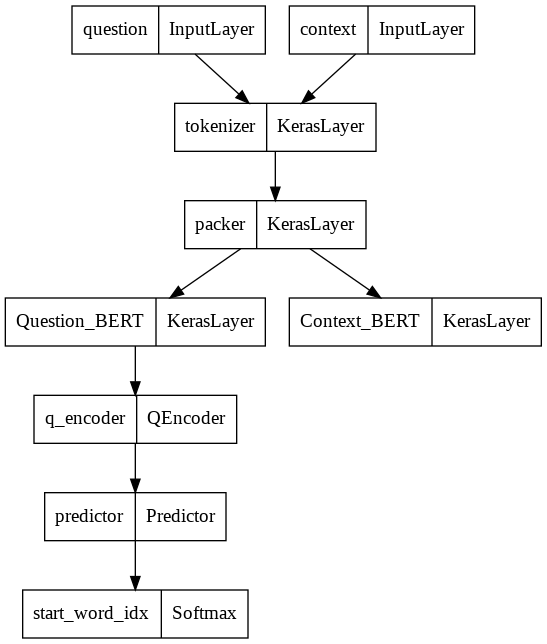

In [ ]:
tf.keras.utils.plot_model(model)

### Training the model

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
context_in = tf.expand_dims(tf.convert_to_tensor(ds_context), axis=1)
questions_in = tf.expand_dims(tf.convert_to_tensor(ds_questions), axis=1)

# answer_start_out = tf.expand_dims(tf.convert_to_tensor(ds_answer_start), axis=1)
answer_start_out = tf.expand_dims(tf.convert_to_tensor(ds_word_start_indices), axis=1)
print(answer_start_out.shape)

(10000, 1)


In [ ]:
req_accuracy = 0.95

class custom_callback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") > req_accuracy:
            self.model.stop_training = True


callback = custom_callback()

In [ ]:
# with tf.device('/device:GPU:0'):
#     model.fit(
#         {"context": context_in, "question": questions_in}, 
#         {"start_idx": answer_start_out},
#         epochs = 200, 
#         callbacks = [callback], 
#         batch_size = 32
#     )

In [ ]:
ds_validation = tfds.load('squad', split='validation[:1000]', shuffle_files=False)
ds_test = tfds.load('squad', split='validation[1000:1200]', shuffle_files=False)

In [ ]:
ds_context_val = [remove_punc(i["context"]) for i in ds_validation]
context_val = tf.expand_dims(tf.convert_to_tensor(ds_context_val), axis=1)

ds_question_val = [remove_punc(i["question"]) for i in ds_validation]
questions_val = tf.expand_dims(tf.convert_to_tensor(ds_question_val), axis=1)

ds_index_val = [i["answers"]["answer_start"][0] for i in ds_validation]
index_val = tf.expand_dims(tf.convert_to_tensor(ds_index_val), axis=1)

ds_answers_val = [remove_punc(i["answers"]["text"]) for i in ds_validation]
ds_word_start_indices_val = [len(tf.strings.split(tf.strings.substr(s, 0, ds_index_val[i]))) for i, s in enumerate(ds_context_val)]
# ds_word_start_indices_val = np.clip(ds_word_start_indices_val, a_min=0, a_max=127)
start_index_val = tf.expand_dims(tf.convert_to_tensor(ds_word_start_indices_val), axis=1) 

ds_word_end_indices_val = [ds_word_start_indices_val[i] + len(tf.strings.split(s[0])) - 1 for i, s in enumerate(ds_answers_val)]
# ds_word_end_indices_val = np.clip(ds_word_end_indices_val, a_min=0, a_max=127)

In [ ]:
ds_context_test = [remove_punc(i["context"]) for i in ds_test]
context_test = tf.expand_dims(tf.convert_to_tensor(ds_context_test), axis=1)

ds_question_test = [remove_punc(i["question"]) for i in ds_test]
questions_test = tf.expand_dims(tf.convert_to_tensor(ds_question_test), axis=1)

ds_index_test = [i["answers"]["answer_start"][0] for i in ds_test]
index_test = tf.expand_dims(tf.convert_to_tensor(ds_index_test), axis=1)

ds_answers_test = [remove_punc(i["answers"]["text"]) for i in ds_test]
ds_word_start_indices_test = [len(tf.strings.split(tf.strings.substr(s, 0, ds_index_val[i]))) for i, s in enumerate(ds_context_test)]
# ds_word_start_indices_test = np.clip(ds_word_start_indices_test, a_min=0, a_max=127)
start_index_test = tf.expand_dims(tf.convert_to_tensor(ds_word_start_indices_test), axis=1) 

ds_word_end_indices_test = [ds_word_start_indices_test[i] + len(tf.strings.split(s[0])) - 1 for i, s in enumerate(ds_answers_test)]
# ds_word_end_indices_test = np.clip(ds_word_end_indices_test, a_min=0, a_max=127)

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(
        {"context": context_in, "question": questions_in}, 
        {"start_word_idx": answer_start_out},
        epochs = 200, 
        callbacks = [callback], 
        batch_size = 4,
        validation_data = ({"context": context_val, "question": questions_val}, 
        {"start_word_idx": start_index_val})
    )

Epoch 1/200
2500/2500 [==============================] - 239s 90ms/step - loss: 140.9600 - accuracy: 0.0097 - val_loss: 4.9939 - val_accuracy: 0.0090
Epoch 2/200
2500/2500 [==============================] - 213s 85ms/step - loss: 10.1022 - accuracy: 0.0101 - val_loss: 4.9635 - val_accuracy: 0.0130
Epoch 3/200
2500/2500 [==============================] - 214s 86ms/step - loss: 27.4917 - accuracy: 0.0116 - val_loss: 4.8847 - val_accuracy: 0.0080
Epoch 4/200
2500/2500 [==============================] - 224s 89ms/step - loss: 5.7011 - accuracy: 0.0200 - val_loss: 5.2750 - val_accuracy: 0.0090
Epoch 5/200
2500/2500 [==============================] - 215s 86ms/step - loss: 5.5148 - accuracy: 0.0389 - val_loss: 5.2675 - val_accuracy: 0.0160
Epoch 6/200
2500/2500 [==============================] - 215s 86ms/step - loss: 4.8000 - accuracy: 0.0572 - val_loss: 5.7758 - val_accuracy: 0.0100
Epoch 7/200
2500/2500 [==============================] - 227s 91ms/step - loss: 4.6538 - accuracy: 0.0743 - 